In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import tensorflow_datasets as tfd 載入失敗 下載應該就掛了
from glob import glob
from tqdm import tqdm
import cv2
import os 
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.applications import *
from sklearn.model_selection import StratifiedKFold

In [2]:
#兩類 dog & cat
num_classes = 2
IMG_SIZE =  128

In [3]:
paths_cat = glob('PetImages/Cat2/*.jpg')
paths_dog = glob('PetImages/Dog2/*.jpg')
len(paths_cat),len(paths_dog)

(5866, 5585)

In [15]:
#過濾照片

for i,path in enumerate(tqdm(paths_cat)):
    try:
        img = cv2.imread(path)[:,:,::-1]
        name = 'PetImages/Cat3/cat%s.jpg'%(i)
        cv2.imwrite(name, img)
    except:
            #print(path)
            continue

for i,path in enumerate(tqdm(paths_dog)):
    try:
        img = cv2.imread(path)[:,:,::-1]
        name = 'PetImages/Dog3/dog%s.jpg'%(i)
        cv2.imwrite(name, img)
    except:
            #print(path)
            continue

100%|█████████████████████████████████████████████████████████████████████████████| 5585/5585 [00:40<00:00, 137.90it/s]


In [3]:
paths_cat = glob('PetImages/Cat3/*.jpg')
paths_dog = glob('PetImages/Dog3/*.jpg')

In [4]:
all_path = paths_cat + paths_dog
random.shuffle(all_path) #打亂排序

# for i,path in enumerate(tqdm(all_path)):
#     all_path[i] = path.replace('\\', '/')

In [5]:
len(all_path)

11437

PetImages/Cat3\cat5005.jpg


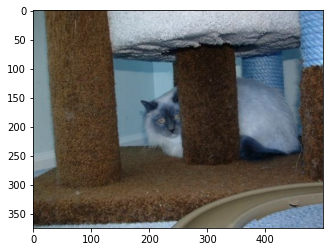

In [6]:
idx = 5
path = all_path[idx]
img = cv2.imread(path)[:,:,::-1]
plt.imshow(img)
print(path)

In [21]:
#split dataset
train_data, test_data = train_test_split(all_path, test_size=0.1)
train_data, val_data = train_test_split(train_data, test_size=0.1)

len(train_data),len(test_data),len(val_data)

(9263, 1144, 1030)

In [8]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))
    
    for i,path in enumerate(tqdm(paths)):
        try:
            img = cv2.imread(path)[:,:,::-1]
            img = cv2.resize(img, (img_size, img_size))
            img = img/255.
            x_data[i] = img

            if test is False:
                filename = os.path.split(path)[0]
                if filename == 'PetImages/Cat3':
                    y_data[i] = 0
                else:
                    y_data[i] = 1
                    
        except:
            #print(path)
            continue
    if not test:
            y_data = utils.to_categorical(y_data, num_classes=num_classes)
            return x_data, y_data
    else:
        return x_data

In [9]:
x_train, y_train = create_dataset(train_data)
x_val, y_val = create_dataset(val_data)
x_test, y_test = create_dataset(test_data)
#x_test = create_dataset(test_data, test = True)

100%|█████████████████████████████████████████████████████████████████████████████| 3432/3432 [00:11<00:00, 292.77it/s]


In [10]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((5603, 128, 128, 3), (5603, 2), (2402, 128, 128, 3), (2402, 2))

In [14]:
#model1
model = models.Sequential([layers.Input((IMG_SIZE, IMG_SIZE, 3)),
                           layers.Conv2D(filters=4, kernel_size=5, activation='relu'),    
                           layers.MaxPool2D(2),
                           layers.Conv2D(filters=8, kernel_size=3, activation='relu'),        
                           layers.MaxPool2D(2),
                           layers.Conv2D(filters=16, kernel_size=3, activation='relu'),
                           layers.MaxPool2D(2),
                           layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
                           layers.MaxPool2D(2),
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(num_classes, activation='sigmoid'),
])

In [17]:
#model2
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.GlobalAveragePooling2D())
#这里也可以添加Dropout层对模型训练神经元进行控制，防止过拟合
model2.add(layers.Dense(2, activation='sigmoid'))
conv_base.trainable = False	#冻结预训练模型的全部层

In [11]:
#model3
base_model = tf.keras.applications.EfficientNetB3(include_top=False, 
                            weights='imagenet', 
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(2, activation='sigmoid')(x)

model3 = models.Model(base_model.input, predictions)

In [10]:
#model4 vgg16

base_model = VGG16(weights='imagenet', include_top=False, pooling=None,
                   input_shape=(IMG_SIZE, IMG_SIZE, 3), classes = 2)

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(2, activation='sigmoid')(x)

model4 = models.Model(inputs=base_model.input, outputs=predictions)

In [26]:
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

In [13]:
model4.compile(loss=losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])#metrics=[metrics.categorical_accuracy]

In [14]:
logs = model4.fit(x_train, y_train,
                 batch_size=64,
                 epochs=10,
                 validation_data=(x_val, y_val))

Epoch 1/10
88/88 [==============================] - 18s 175ms/step - loss: 0.2477 - accuracy: 0.8983 - val_loss: 0.2556 - val_accuracy: 0.8959
Epoch 2/10
88/88 [==============================] - 13s 144ms/step - loss: 0.2419 - accuracy: 0.9004 - val_loss: 0.2536 - val_accuracy: 0.8955
Epoch 3/10
88/88 [==============================] - 13s 146ms/step - loss: 0.2332 - accuracy: 0.9047 - val_loss: 0.2953 - val_accuracy: 0.8789
Epoch 4/10
88/88 [==============================] - 13s 147ms/step - loss: 0.2308 - accuracy: 0.9065 - val_loss: 0.2511 - val_accuracy: 0.8997
Epoch 5/10
88/88 [==============================] - 13s 149ms/step - loss: 0.2335 - accuracy: 0.9056 - val_loss: 0.2691 - val_accuracy: 0.8951
Epoch 6/10
88/88 [==============================] - 13s 148ms/step - loss: 0.2197 - accuracy: 0.9097 - val_loss: 0.2616 - val_accuracy: 0.8930
Epoch 7/10
88/88 [==============================] - 13s 148ms/step - loss: 0.2248 - accuracy: 0.9056 - val_loss: 0.2814 - val_accuracy: 0.8764

In [15]:
model4.save('vgg16.h5')

In [16]:
load_model = tf.keras.models.load_model('vgg16.h5')

# 驗證模型
score = load_model.evaluate(x_test, y_test, verbose=0)

# 輸出結果
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# A: Test loss: 0.0
# A: Test accuracy: 1.0

Test loss: 0.2566949725151062
Test accuracy: 0.8901515007019043


In [17]:
history = logs.history

In [18]:
min_loss_epoch = np.argmin(history['val_loss'])
print('min_loss_epoch: ', min_loss_epoch)
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

min_loss_epoch:  9
val loss  0.24718672037124634
val acc 0.9013321995735168


Text(0.5, 1.0, 'accuracy')

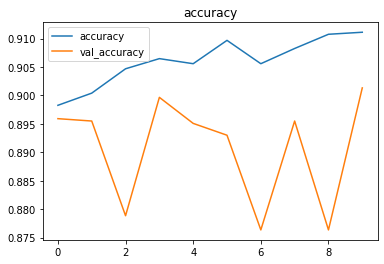

In [19]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

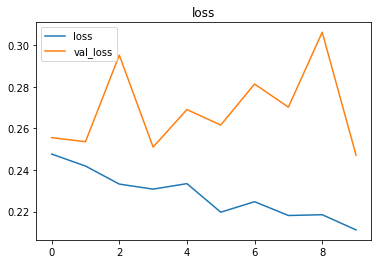

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
#Make Submission file

predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df